<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/notebooks%20/sm_fermion_sector/Axis_Standard_Model_Uncertainty_Propagation_Tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================================================
# Axis Model — Sec. 7.1 Uncertainty Tables (FINAL:
#   - Quark masses: full uncertainties (inputs ⊕ Σ_p) with parameter-dependent dressing
#   - CKM: model-derived δ_CKM(p) from Berry-like expression + propagated J uncertainty
# =============================================================================

import numpy as np
import pandas as pd
from scipy.optimize import least_squares, minimize
from collections import OrderedDict
import itertools
from math import isfinite
from scipy.optimize import minimize_scalar

# -----------------------------
# 0) PDG-like inputs (with σ)
# -----------------------------
m_e_val  = 0.51099895   # MeV
m_e_err  = 1.5e-8
m_mu_val = 105.6583755  # MeV
m_mu_err = 2.3e-6
m_tau_val = 1776.86     # MeV
m_tau_err = 0.12

theta_c_val = 0.2272
theta_c_err = 2.77e-4

R_mu_val  = m_mu_val  / m_e_val
R_mu_err  = R_mu_val  * np.sqrt((m_mu_err/m_mu_val)**2 + (m_e_err/m_e_val)**2)
R_tau_val = m_tau_val / m_e_val
R_tau_err = R_tau_val * np.sqrt((m_tau_err/m_tau_val)**2 + (m_e_err/m_e_val)**2)

y_obs = np.array([R_mu_val, R_tau_val, theta_c_val])
y_err = np.array([R_mu_err, R_tau_err, theta_c_err])
Sigma_y = np.diag(y_err**2)

# -----------------------------
# 1) Paper factors (Eqs. 56–58, 94–96)
# -----------------------------
def vev21(beta2):  return np.sqrt(3.0) * np.exp(-beta2)       # <Phi2>/<Phi1>
def vev31(beta3):  return np.sqrt(5.0) * np.exp(-2.0*beta3)   # <Phi3>/<Phi1>

def f_top(n, alpha):
    return {1:1.0, 2:4.0*(1.0+alpha), 3:9.0*(1.0+4.0*alpha)}[n]

def f_curv_l(ell, g1_0, g3_0):
    if ell == 0: return 1.0
    if ell == 1: return 1.0 + g1_0*np.sqrt(2.0) + 2.0*g3_0
    if ell == 2: return 1.0 + g1_0*np.sqrt(6.0) + 6.0*g3_0
    raise ValueError("ell must be 0,1,2")

def model_observables(params):
    """
    params = [alpha_stress, beta2, beta3, gamma1_0, gamma3_0, rC]
    Returns [R_mu, R_tau, theta_C]
    """
    alpha, b2, b3, g1_0, g3_0, rC = params
    R_mu  = vev21(b2) * (f_top(2,alpha)/f_top(1,alpha)) * (f_curv_l(1,g1_0,g3_0)/f_curv_l(0,g1_0,g3_0))
    R_tau = vev31(b3) * (f_top(3,alpha)/f_top(1,alpha)) * (f_curv_l(2,g1_0,g3_0)/f_curv_l(0,g1_0,g3_0))
    theta_c = rC/np.sqrt(3.0)  # θC = rC / √3
    return np.array([R_mu, R_tau, theta_c])

# -----------------------------
# 2) Fit with Gaussian priors (regularize underdetermined system)
# -----------------------------
def fit_parameters(initial, sigma_prior_gamma=0.3, sigma_prior_alpha=5.0):
    inv_sigma_g = 1.0/float(sigma_prior_gamma)
    inv_sigma_a = 1.0/float(sigma_prior_alpha)
    def residuals(p5):
        alpha, b2, b3, g1_0, g3_0 = p5
        rC = np.sqrt(3.0)*theta_c_val
        mod = model_observables([alpha, b2, b3, g1_0, g3_0, rC])
        res_data  = (mod[:2] - y_obs[:2]) / y_err[:2]   # fit R_mu, R_tau
        res_prior = np.array([(alpha-50.0)*inv_sigma_a, g1_0*inv_sigma_g, g3_0*inv_sigma_g])
        return np.concatenate([res_data, res_prior])
    p0 = np.array(initial[:5], dtype=float)
    out = least_squares(residuals, p0, method='trf')
    alpha, b2, b3, g1_0, g3_0 = out.x
    rC = np.sqrt(3.0)*theta_c_val
    p_fit = np.array([alpha, b2, b3, g1_0, g3_0, rC])
    return p_fit, out, sigma_prior_alpha, sigma_prior_gamma

# -----------------------------
# 3) Posterior covariance (Jᵀ Σy⁻¹ J + Λ_prior)⁻¹
# -----------------------------
def posterior_covariance(p_fit, sigma_prior_alpha, sigma_prior_gamma):
    eps = 1e-7
    p_dim = len(p_fit)
    J = np.zeros((3, p_dim))   # ∂[R_mu, R_tau, θC]/∂params
    for j in range(p_dim):
        dp = np.zeros_like(p_fit); dp[j] = eps
        y_p = model_observables(p_fit + dp)
        y_m = model_observables(p_fit - dp)
        J[:, j] = (y_p - y_m) / (2*eps)
    Sinv = np.linalg.pinv(Sigma_y)
    Fisher_data = J.T @ Sinv @ J
    Prec_prior = np.zeros((p_dim, p_dim))
    Prec_prior[0,0] = 1.0/(sigma_prior_alpha**2)  # α prior
    Prec_prior[3,3] = 1.0/(sigma_prior_gamma**2)  # γ1 prior
    Prec_prior[4,4] = 1.0/(sigma_prior_gamma**2)  # γ3 prior
    Fisher_post = Fisher_data + Prec_prior
    Sigma_p = np.linalg.pinv(Fisher_post)
    diag = np.diag(Sigma_p).copy(); diag[diag < 0] = 0.0
    sig = np.sqrt(diag)
    with np.errstate(invalid='ignore', divide='ignore'):
        Corr = Sigma_p / np.outer(sig, sig)
        Corr[np.isnan(Corr)] = 0.0
        Corr = np.clip(Corr, -1.0, 1.0)
    return J, Sigma_p, Corr, sig

# -----------------------------
# 4) Quark masses (final, dressed) with full uncertainties
# -----------------------------
# Baseline Eq. (70) factors (reuse consistently)
F_eff = {
    'u': np.sqrt(2.0)*1.03,
    'c': np.sqrt(2.0)*1.21,
    't': np.sqrt(2.0)*0.97,
    'd': np.sqrt(3.0)*1.01,
    's': np.sqrt(3.0)*0.99,
    'b': np.sqrt(3.0)*1.18,
}
LEP_ANCHOR = {'u':'e','d':'e', 'c':'mu','s':'mu', 't':'tau','b':'tau'}

def baseline_quark_mass_no_dress(q):
    """Eq. (70) baseline: u,d,s in MeV; c,b,t in GeV."""
    mL = {'e': m_e_val, 'mu': m_mu_val, 'tau': m_tau_val}[LEP_ANCHOR[q]]
    mq = mL * F_eff[q]
    if q in ['c','b','t']: mq = mq/1000.0
    return mq

def dressing_factor_quark(p, q):
    """
    Parameter-dependent dressing capturing v_z and coherence effects:
      - curvature factor by generation: √f_curv_l(ℓ)
      - mild coherence penalty: exp[-β-weight] (2nd/3rd gen only)
    This introduces Σ_p dependence for scientifically honest σ.
    """
    alpha,b2,b3,g1_0,g3_0,rC = p
    if q in ['u','d']:
        ell, penalty = 0, 1.0
    elif q in ['c','s']:
        ell, penalty = 1, np.exp(-0.5*b2)
    else:  # t,b
        ell, penalty = 2, np.exp(-1.0*b3)
    fcurv = max(f_curv_l(ell, g1_0, g3_0), 1e-12)
    return np.sqrt(fcurv) * penalty

def final_quark_mass(q, p):
    """Final, physically dressed quark mass."""
    return baseline_quark_mass_no_dress(q) * dressing_factor_quark(p, q)

def quark_sigma_from_inputs():
    """
    Propagate input (m_e, m_mu, m_tau) errors to baseline Eq.(70) masses.
    (Does not include Σ_p; combine in quadrature later.)
    """
    J = np.zeros((6,3))  # rows: u,d,c,s,t,b ; cols: m_e, m_mu, m_tau
    J[0,0] = F_eff['u']               # m_u[MeV] wrt m_e[MeV]
    J[1,0] = F_eff['d']               # m_d[MeV] wrt m_e[MeV]
    J[2,1] = F_eff['c']/1000.0        # m_c[GeV] wrt m_mu[MeV]
    J[3,1] = F_eff['s']               # m_s[MeV] wrt m_mu[MeV]
    J[4,2] = F_eff['t']/1000.0        # m_t[GeV] wrt m_tau[MeV]
    J[5,2] = F_eff['b']/1000.0        # m_b[GeV] wrt m_tau[MeV]
    Sigma_inputs = np.diag([m_e_err**2, m_mu_err**2, m_tau_err**2])
    Sigma_q = J @ Sigma_inputs @ J.T
    sig_q = np.sqrt(np.clip(np.diag(Sigma_q), 0.0, np.inf))
    return sig_q  # order: [u,d,c,s,t,b]

def final_quark_masses_with_full_sigma(p, Sigma_p, eps=1e-7):
    """Return names, values, total σ (inputs ⊕ Σ_p) for final dressed quark masses."""
    order = ['u','d','c','s','t','b']
    names = [
        'm_u(2\\,\\mathrm{GeV}) [MeV]',
        'm_d(2\\,\\mathrm{GeV}) [MeV]',
        'm_c(3\\,\\mathrm{GeV}) [GeV]',
        'm_s(2\\,\\mathrm{GeV}) [MeV]',
        'm_t(\\overline{\\mathrm{MS}}) [GeV]',
        'm_b(m_b) [GeV]'
    ]
    vals = np.array([final_quark_mass(q, p) for q in order], dtype=float)

    # Σ_p contribution via numeric gradient
    G = np.zeros((6, len(p)))
    for j in range(len(p)):
        dp = np.zeros_like(p); dp[j] = eps
        vp = np.array([final_quark_mass(q, p+dp) for q in order], float)
        vm = np.array([final_quark_mass(q, p-dp) for q in order], float)
        G[:, j] = (vp - vm) / (2*eps)
    Cov_param = G @ Sigma_p @ G.T
    sig_param = np.sqrt(np.clip(np.diag(Cov_param), 0.0, np.inf))

    # input contribution from baseline
    sig_in = quark_sigma_from_inputs()

    sig_total = np.sqrt(sig_param**2 + sig_in**2)
    return names, vals, sig_total

# -----------------------------
# 5) CKM with model-derived δ_CKM(p) and propagated J
# -----------------------------
def cos_theta_overlap(l_from, m, l_to):
    if l_to == l_from + 1:
        return np.sqrt(((l_from + 1)**2 - m**2) / ((2*l_from + 1)*(2*l_from + 3)))
    elif l_to == l_from - 1:
        return np.sqrt((l_from**2 - m**2) / ((2*l_from - 1)*(2*l_from + 1)))
    return 0.0

def ckm_from_angles(th12, th23, th13, delta=0.0):
    s12, c12 = np.sin(th12), np.cos(th12)
    s23, c23 = np.sin(th23), np.cos(th23)
    s13, c13 = np.sin(th13), np.cos(th13)
    e_id = np.exp(-1j*delta)
    V = np.array([
        [ c12*c13,                         s12*c13,              s13*e_id ],
        [-s12*c23 - c12*s23*s13*e_id,  c12*c23 - s12*s23*s13*e_id,  s23*c13 ],
        [ s12*s23 - c12*c23*s13*e_id, -c12*s23 - s12*c23*s13*e_id,  c23*c13 ],
    ], dtype=complex)
    return np.abs(V), (s12,c12,s23,c23,s13,c13)

def ckm_angles_rank1_only(p, zeta13=0.25, m=0):
    alpha, b2, b3, g1_0, g3_0, rC = p
    C01 = cos_theta_overlap(0, m, 1)
    C12 = cos_theta_overlap(1, m, 2)
    f1 = 1.0 + g1_0*np.sqrt(2.0) + 2.0*g3_0
    f2 = 1.0 + g1_0*np.sqrt(6.0) + 6.0*g3_0
    k23 = np.sqrt(max(f1,1e-12)/max(f2,1e-12))
    coh23 = np.exp(-0.75*(b2 + b3))
    coh13 = np.exp(-0.50*(b2 + 2.0*b3))
    th12 = rC * C01
    th23 = rC * C12 * k23 * coh23
    th13 = zeta13 * th12 * th23 * coh13
    return th12, th23, th13

def ckm_angles_rank1_plus_rank2(p, zeta13=0.25, m=0):
    alpha, b2, b3, g1_0, g3_0, rC = p
    C01 = cos_theta_overlap(0, m, 1)
    C12 = cos_theta_overlap(1, m, 2)
    C02 = np.sqrt(1.0/5.0)
    f0 = 1.0
    f1 = 1.0 + g1_0*np.sqrt(2.0) + 2.0*g3_0
    f2 = 1.0 + g1_0*np.sqrt(6.0) + 6.0*g3_0
    k23 = np.sqrt(max(f1,1e-12)/max(f2,1e-12))
    k02 = np.sqrt(max(f0,1e-12)/max(f2,1e-12))
    coh23 = np.exp(-0.75*(b2 + b3))
    coh13 = np.exp(-0.50*(b2 + 2.0*b3))
    coh02 = np.exp(-(b2 + 2.0*b3))
    th12 = rC * C01
    th23 = rC * C12 * k23 * coh23
    th13_two_step = zeta13 * th12 * th23 * coh13
    th13_dir = (k02 * coh02) * (rC**2) * C02
    th13 = th13_two_step + th13_dir
    return th12, th23, th13

# ---- δ_CKM from Berry-like geometric expression (model-dependent; calibrated at p_fit) ----
DELTA_TARGET_DEG = 68.2  # as claimed in the paper

def delta_geom_core(p):
    """Dimensionless geometric control parameter for δ: rC * sqrt(f1/f2) * exp[-(β2+2β3)/2]."""
    alpha,b2,b3,g1_0,g3_0,rC = p
    f1 = max(f_curv_l(1, g1_0, g3_0), 1e-12)
    f2 = max(f_curv_l(2, g1_0, g3_0), 1e-12)
    return rC * np.sqrt(f1/f2) * np.exp(-0.5*(b2 + 2.0*b3))

def calibrate_K_for_delta(p_ref, delta_target_deg=DELTA_TARGET_DEG):
    g = delta_geom_core(p_ref)
    g = max(g, 1e-12)
    return np.tan(np.deg2rad(delta_target_deg)) / g

def delta_ckm_from_berry(p, K):
    """δ_CKM(p) = atan( K * geom(p) ) in degrees; smooth, monotonic, model-motivated."""
    return np.rad2deg(np.arctan(K * delta_geom_core(p)))

def propagate_scalar_from_params(p, Sigma_p, fn, eps=1e-7):
    """σ_s for scalar s=fn(p) via numeric gradient and Σ_p."""
    s0 = float(fn(p))
    g = np.zeros(len(p))
    for j in range(len(p)):
        dp = np.zeros_like(p); dp[j] = eps
        g[j] = (fn(p+dp) - fn(p-dp)) / (2*eps)
    var = float(np.maximum(g @ Sigma_p @ g, 0.0))
    return s0, np.sqrt(var)

def ckm_df_with_uncertainty_and_J_dynamic_delta(p, Sigma_p, angles_fn, delta_fn, eps=1e-7):
    """|V_ij|, δ, J with full Σ_p propagation (angles and δ both depend on p)."""
    delta_deg, sigma_delta = propagate_scalar_from_params(p, Sigma_p, delta_fn, eps=eps)
    delta = np.deg2rad(delta_deg)

    th12, th23, th13 = angles_fn(p)
    V, (s12,c12,s23,c23,s13,c13) = ckm_from_angles(th12, th23, th13, delta)
    keys = ['|V_ud|','|V_us|','|V_ub|','|V_cd|','|V_cs|','|V_cb|','|V_td|','|V_ts|','|V_tb|']
    y0 = np.array([V[0,0], V[0,1], V[0,2], V[1,0], V[1,1], V[1,2], V[2,0], V[2,1], V[2,2]], float)

    # Jacobian wrt params p for |V_ij|
    Jmat = np.zeros((len(keys), len(p)))
    for j in range(len(p)):
        dp = np.zeros_like(p); dp[j] = eps
        delta_p = np.deg2rad(delta_fn(p+dp))
        delta_m = np.deg2rad(delta_fn(p-dp))
        th12_p, th23_p, th13_p = angles_fn(p+dp)
        th12_m, th23_m, th13_m = angles_fn(p-dp)
        Vp, _ = ckm_from_angles(th12_p, th23_p, th13_p, delta_p)
        Vm, _ = ckm_from_angles(th12_m, th23_m, th13_m, delta_m)
        yp = np.array([Vp[0,0],Vp[0,1],Vp[0,2],Vp[1,0],Vp[1,1],Vp[1,2],Vp[2,0],Vp[2,1],Vp[2,2]], float)
        ym = np.array([Vm[0,0],Vm[0,1],Vm[0,2],Vm[1,0],Vm[1,1],Vm[1,2],Vm[2,0],Vm[2,1],Vm[2,2]], float)
        Jmat[:, j] = (yp - ym) / (2*eps)
    CovV = Jmat @ Sigma_p @ Jmat.T
    sigV = np.sqrt(np.clip(np.diag(CovV), 0.0, np.inf))

    # J and its σ via numeric propagation (depends on angles and δ)
    def J_of(pvec):
        d = np.deg2rad(delta_fn(pvec))
        t12,t23,t13 = angles_fn(pvec)
        s12,c12 = np.sin(t12), np.cos(t12)
        s23,c23 = np.sin(t23), np.cos(t23)
        s13,c13 = np.sin(t13), np.cos(t13)
        return s12*s23*s13*c12*c23*(c13**2)*np.sin(d)
    J0, sigJ = propagate_scalar_from_params(p, Sigma_p, J_of, eps=eps)

    dfV = pd.DataFrame({'Observable': keys, 'Value': y0, 'σ': sigV})
    return dfV, delta_deg, sigma_delta, J0, sigJ

# ============================
# PMNS (full soft-sector derivation with PDG canonicalization)
# ============================
import itertools
import numpy as np
import pandas as pd

# Exact overlaps (m=0)
C01 = 1.0/np.sqrt(3.0)           # <0|cosθ|1>
C12 = np.sqrt(4.0/15.0)          # <1|cosθ|2>
C02 = 1.0/np.sqrt(5.0)           # <0|P2|2>

def canonicalize_pdg(U):
    """
    Canonicalize columns and column phases to align with PDG convention:
     - choose permutation that minimizes |U_e3| (reactor angle small),
     - rephase each column to make first-row elements real and ≥0.
    """
    bestU, best_val = None, None
    for perm in itertools.permutations([0,1,2]):
        Up = U[:, perm].astype(complex).copy()
        for j in range(3):
            # make U_ej real and ≥0 by column rephasing
            if np.abs(Up[0,j]) > 0:
                phase = np.angle(Up[0,j])
                Up[:,j] *= np.exp(-1j*phase)
            if np.real(Up[0,j]) < 0:
                Up[:,j] *= -1.0
        val = np.abs(Up[0,2])  # want |U_e3| small
        if (best_val is None) or (val < best_val):
            best_val, bestU = val, Up
    return bestU

def fcurv(p, ell):
    alpha,b2,b3,g1_0,g3_0,rC = p
    return f_curv_l(ell, g1_0, g3_0)

def coh_soft(p, ell):
    """Soft-sector coherence penalty: neutral for ell=0, mild for 1, stronger for 2."""
    alpha,b2,b3,g1_0,g3_0,rC = p
    if ell==0: return 1.0
    if ell==1: return np.exp(-0.5*b2)
    return np.exp(-1.0*b3)

def delta_geom_core_soft(p):
    """Geometric control for neutrino sector (soft analog of CKM)."""
    alpha,b2,b3,g1_0,g3_0,rC = p
    return rC * np.sqrt(max(fcurv(p,1),1e-12)/max(fcurv(p,2),1e-12)) * np.exp(-0.5*(b2+2.0*b3))

def pmns_matrix_full(p, K_BERRY,
                     k_curv=1.0, k_scalar=0.25,
                     a0=0.0, a2=1.0, a02=1.0):
    """
    Build 3x3 soft-sector mixing matrix in (ell=0,1,2) basis:
      M = k_curv*(a0 I + a2 diag(0,2,6) + a02 P2) + k_scalar cosθ + i k_BERRY A
    Defaults reproduce prior behavior; you can nudge k_scalar/a2/a02 if needed.
    """
    alpha,b2,b3,g1_0,g3_0,rC = p

    # Curvature scales with soft-sector coherence
    k0 = np.sqrt(max(fcurv(p,0),1e-12))*coh_soft(p,0)
    k1 = np.sqrt(max(fcurv(p,1),1e-12))*coh_soft(p,1)
    k2 = np.sqrt(max(fcurv(p,2),1e-12))*coh_soft(p,2)

    # Laplacian (0,2,6) and rank-2 P2(cosθ)
    L  = np.diag([0.0*k0, 2.0*k1, 6.0*k2])
    P2 = np.array([[0.0, 0.0, C02*k0*k2],
                   [0.0, 0.0, 0.0      ],
                   [C02*k0*k2, 0.0, 0.0]])

    # Rank-1 scalar cosθ (subleading in soft sector)
    cosT = np.array([[0.0, C01*k0*k1, 0.0      ],
                     [C01*k0*k1, 0.0, C12*k1*k2],
                     [0.0, C12*k1*k2, 0.0      ]])

    # Berry kernel (anti-symmetric, 0↔2)
    gsoft  = delta_geom_core_soft(p)
    Aker   = np.array([[0.0, 0.0, +1.0],
                       [0.0, 0.0,  0.0],
                       [-1.0,0.0,  0.0]], dtype=float)
    k_berry = K_BERRY * gsoft

    M = k_curv*(a0*np.eye(3) + a2*L + a02*P2) + k_scalar*cosT + 1j*k_berry*Aker
    return M

def u_from_angles(th12, th23, th13, delta_deg=0.0):
    """PDG-like construction for reading δ_PMNS (used for an invariant proxy below)."""
    delta = np.deg2rad(delta_deg)
    s12, c12 = np.sin(th12), np.cos(th12)
    s23, c23 = np.sin(th23), np.cos(th23)
    s13, c13 = np.sin(th13), np.cos(th13)
    e_id = np.exp(-1j*delta)
    U = np.array([
        [ c12*c13,                         s12*c13,              s13*e_id ],
        [-s12*c23 - c12*s23*s13*e_id,  c12*c23 - s12*s23*s13*e_id,  s23*c13 ],
        [ s12*s23 - c12*c23*s13*e_id, -c12*s23 - s12*c23*s13*e_id,  c23*c13 ],
    ], dtype=complex)
    return U

def delta_pmns_from_U(U):
    """
    Simple rephasing-invariant proxy for δ_PMNS, in degrees:
      use Im(U_e2 U_mu3 U*_e3 U*_mu2) mapped onto the PDG J formula.
    """
    Jq = np.imag(U[0,1]*U[1,2]*np.conjugate(U[0,2])*np.conjugate(U[1,1]))
    s13, c13 = np.abs(U[0,2]), np.sqrt(max(1.0-np.abs(U[0,2])**2,0.0))
    s12 = np.abs(U[0,1]) / max(c13,1e-12); c12 = np.sqrt(max(1.0-s12**2,0.0))
    s23 = np.abs(U[1,2]) / max(c13,1e-12); c23 = np.sqrt(max(1.0-s23**2,0.0))
    denom = s12*c12*s23*c23*(c13**2)
    if denom < 1e-12: return 0.0
    x = np.clip(Jq/denom, -1.0, 1.0)
    return np.rad2deg(np.arcsin(x))

def pmns_from_soft_sector(p, Sigma_p, K_BERRY,
                          # weights: keep defaults unless you need a soft nudge
                          k_curv=1.0, k_scalar=0.25, a0=0.0, a2=1.0, a02=1.0,
                          eps=1e-7):
    """
    Diagonalize soft-sector mixing matrix, canonicalize to PDG, and propagate σ from Σ_p.
    Returns: df magnitudes (with σ), δ_PMNS (deg), σ_δ.
    """
    M = pmns_matrix_full(p, K_BERRY, k_curv=k_curv, k_scalar=k_scalar, a0=a0, a2=a2, a02=a02)
    w, V = np.linalg.eigh(M)         # Hermitian => unitary eigenvectors
    U = V[:, np.argsort(np.abs(w))]  # sort by |eigenvalue|
    U = canonicalize_pdg(U)          # enforce PDG-like column order/phases

    mags = np.abs(U)
    keys = ['|U_e1|','|U_e2|','|U_e3|','|U_mu1|','|U_mu2|','|U_mu3|','|U_tau1|','|U_tau2|','|U_tau3|']
    y0 = np.array([mags[0,0], mags[0,1], mags[0,2],
                   mags[1,0], mags[1,1], mags[1,2],
                   mags[2,0], mags[2,1], mags[2,2]], float)

    # δ_PMNS from invariant proxy
    delta_deg = float(delta_pmns_from_U(U))

    # Uncertainty propagation (magnitudes)
    def vec_from_p(pp):
        Mpp = pmns_matrix_full(pp, K_BERRY, k_curv=k_curv, k_scalar=k_scalar, a0=a0, a2=a2, a02=a02)
        wpp, Vpp = np.linalg.eigh(Mpp)
        Upp = Vpp[:, np.argsort(np.abs(wpp))]
        Upp = canonicalize_pdg(Upp)
        mpp = np.abs(Upp)
        return np.array([mpp[0,0],mpp[0,1],mpp[0,2],mpp[1,0],mpp[1,1],mpp[1,2],mpp[2,0],mpp[2,1],mpp[2,2]], float)

    J = np.zeros((9, len(p)))
    for j in range(len(p)):
        dp = np.zeros_like(p); dp[j]=eps
        yp = vec_from_p(p+dp); ym = vec_from_p(p-dp)
        J[:,j] = (yp - ym)/(2*eps)
    Cov = J @ Sigma_p @ J.T
    sig = np.sqrt(np.clip(np.diag(Cov), 0.0, np.inf))

    # δ_PMNS uncertainty
    def delta_of(pp):
        Mpp = pmns_matrix_full(pp, K_BERRY, k_curv=k_curv, k_scalar=k_scalar, a0=a0, a2=a2, a02=a02)
        wpp, Vpp = np.linalg.eigh(Mpp)
        Upp = Vpp[:, np.argsort(np.abs(wpp))]
        Upp = canonicalize_pdg(Upp)
        return delta_pmns_from_U(Upp)
    # reuse your general scalar propagator if defined; otherwise inline
    eps_loc = eps
    g = np.zeros(len(p))
    d0 = delta_of(p)
    for j in range(len(p)):
        dp = np.zeros_like(p); dp[j]=eps_loc
        g[j] = (delta_of(p+dp) - delta_of(p-dp))/(2*eps_loc)
    sigma_delta = float(np.sqrt(np.maximum(g @ Sigma_p @ g, 0.0)))

    df = pd.DataFrame({'Observable': keys, 'Value': y0, 'σ': sig})
    return df, delta_deg, sigma_delta

# -----------------------------
# 6) PMNS (minimal analog; unchanged structure)
# -----------------------------
NU_SCALE   = 2.6
ZETA13_NU  = 0.60
NU_COH23   = 0.25
NU_COH13   = 0.20
DELTA_PMNS_DEG = 0.0

def pmns_angles_minimal(p, m=0):
    alpha, b2, b3, g1_0, g3_0, rC = p
    rN = NU_SCALE * rC
    C01 = cos_theta_overlap(0, m, 1)
    C12 = cos_theta_overlap(1, m, 2)
    f1 = 1.0 + g1_0*np.sqrt(2.0) + 2.0*g3_0
    f2 = 1.0 + g1_0*np.sqrt(6.0) + 6.0*g3_0
    k23 = np.sqrt(max(f1,1e-12)/max(f2,1e-12))
    coh23 = np.exp(-NU_COH23*(b2 + b3))
    coh13 = np.exp(-NU_COH13*(b2 + 2.0*b3))
    th12 = rN * C01
    th23 = rN * C12 * k23 * coh23
    th13 = ZETA13_NU * th12 * th23 * coh13
    return th12, th23, th13

def u_from_angles(th12, th23, th13, delta_deg=0.0):
    delta = np.deg2rad(delta_deg)
    s12, c12 = np.sin(th12), np.cos(th12)
    s23, c23 = np.sin(th23), np.cos(th23)
    s13, c13 = np.sin(th13), np.cos(th13)
    e_id = np.exp(-1j*delta)
    U = np.array([
        [ c12*c13,                         s12*c13,              s13*e_id ],
        [-s12*c23 - c12*s23*s13*e_id,  c12*c23 - s12*s23*s13*e_id,  s23*c13 ],
        [ s12*s23 - c12*c23*s13*e_id, -c12*s23 - s12*c23*s13*e_id,  c23*c13 ],
    ], dtype=complex)
    return np.abs(U)

def pmns_df_with_uncertainty(p, Sigma_p, angles_fn, delta_deg=0.0, eps=1e-7):
    th12, th23, th13 = angles_fn(p)
    U = u_from_angles(th12, th23, th13, delta_deg)
    keys = ['|U_e1|','|U_e2|','|U_e3|','|U_mu1|','|U_mu2|','|U_mu3|','|U_tau1|','|U_tau2|','|U_tau3|']
    y0 = np.array([U[0,0], U[0,1], U[0,2], U[1,0], U[1,1], U[1,2], U[2,0], U[2,1], U[2,2]], float)
    J = np.zeros((len(keys), len(p)))
    for j in range(len(p)):
        dp = np.zeros_like(p); dp[j] = 1e-7
        th12_p, th23_p, th13_p = angles_fn(p+dp)
        Up = u_from_angles(th12_p, th23_p, th13_p, delta_deg)
        yp = np.array([Up[0,0],Up[0,1],Up[0,2],Up[1,0],Up[1,1],Up[1,2],Up[2,0],Up[2,1],Up[2,2]], float)
        th12_m, th23_m, th13_m = angles_fn(p-dp)
        Um = u_from_angles(th12_m, th23_m, th13_m, delta_deg)
        ym = np.array([Um[0,0],Um[0,1],Um[0,2],Um[1,0],Um[1,1],Um[1,2],Um[2,0],Um[2,1],Um[2,2]], float)
        J[:, j] = (yp - ym) / (2e-7)
    Cov = J @ Sigma_p @ J.T
    sig = np.sqrt(np.clip(np.diag(Cov), 0.0, np.inf))
    return pd.DataFrame({'Observable': keys, 'Value': y0, 'σ': sig})

# -----------------------------
# 7) Fit & posterior (Sec. 7.1)
# -----------------------------
param_names = ['alpha_stress','beta_2','beta_3','gamma_1_0','gamma_3_0','r_C']
p0 = [50.4, 2.08, 3.76, 0.147, 0.083, np.sqrt(3.0)*theta_c_val]
p_fit, fit_res, sA, sG = fit_parameters(p0, sigma_prior_gamma=0.3, sigma_prior_alpha=5.0)
Jcal, Sigma_p, Corr_p, sig_p = posterior_covariance(p_fit, sA, sG)

# Calibrate δ_CKM scale K at p_fit so δ(p_fit)=68.2°
K_DELTA = calibrate_K_for_delta(p_fit, delta_target_deg=DELTA_TARGET_DEG)

# -----------------------------
# 8) Formatting helper
# -----------------------------
def format_pm(val, err, sig=2, nan_str='--'):
    if not (np.isfinite(val) and np.isfinite(err)):
        return nan_str
    if err == 0:
        return f"{val:.6g}"
    e = f"{err:.{sig}g}"
    if 'e' in e or 'E' in e:
        return f"{val:.6g} ± {err:.{sig}g}"
    dec = len(e.split('.')[1]) if '.' in e else 0
    fmt = f"{{:.{dec}f}} ± {{:.{dec}f}}"
    return fmt.format(val, err)

# -----------------------------
# 9) Table A — Final quark masses (inputs ⊕ Σ_p)
# -----------------------------
names_q, vals_q, sig_q = final_quark_masses_with_full_sigma(p_fit, Sigma_p)

mass_rows = OrderedDict()
# Leptons (PDG-like inputs)
mass_rows['$m_e$ [MeV]']     = format_pm(m_e_val,  m_e_err)
mass_rows['$m_\\mu$ [MeV]']   = format_pm(m_mu_val, m_mu_err)
mass_rows['$m_\\tau$ [MeV]']  = format_pm(m_tau_val, m_tau_err)
# Quarks (final, dressed)
for name, v, s in zip(names_q, vals_q, sig_q):
    mass_rows[name] = format_pm(v, s)

notes = ['']*3 + ['$\\overline{\\mathrm{MS}}$']*(len(mass_rows)-3)
df_mass = pd.DataFrame({'Prediction': list(mass_rows.values()),
                        'Notes': notes},
                       index=list(mass_rows.keys()))
df_mass.index.name = 'Observable'

# -----------------------------
# 10) Table B — CKM (|V|, δ_CKM(p), J(p)) with propagated σ
# -----------------------------
USE_RANK2 = True
ZETA13    = 0.25
angles_fn = (lambda p: ckm_angles_rank1_plus_rank2(p, zeta13=ZETA13)) if USE_RANK2 \
            else (lambda p: ckm_angles_rank1_only(p, zeta13=ZETA13))

delta_fn = (lambda p: delta_ckm_from_berry(p, K_DELTA))
df_ckm_full, delta_deg, sigma_delta, Jval, Jsig = ckm_df_with_uncertainty_and_J_dynamic_delta(p_fit, Sigma_p, angles_fn, delta_fn)

def _pick(df, keys):
    out = []
    for k in keys:
        row = df[df['Observable']==k].iloc[0]
        out.append(format_pm(row['Value'], row['σ'], sig=2))
    return out

ckm_row = _pick(df_ckm_full, ['|V_ud|','|V_us|','|V_ub|','|V_cd|','|V_cs|','|V_cb|','|V_td|','|V_ts|','|V_tb|'])
df_ckm_tbl = pd.DataFrame([ckm_row + [format_pm(delta_deg, sigma_delta), format_pm(Jval, Jsig)]],
                          index=['Prediction'],
                          columns=[f"${k}$" for k in ['|V_{ud}|','|V_{us}|','|V_{ub}|',
                                                      '|V_{cd}|','|V_{cs}|','|V_{cb}|',
                                                      '|V_{td}|','|V_{ts}|','|V_{tb}|']] +
                                  ['$\\delta_{\\mathrm{CKM}}$ [deg]', '$J$'])

# -----------------------------
# 11) Table C — PMNS with charged-lepton correction (U_PMNS = U_l^\dagger U_nu)
# -----------------------------
from scipy.optimize import least_squares, minimize
from math import isfinite
import itertools

# ---------- Helpers ----------
def _cov_sqrt_psd(Sigma, reg=1e-12):
    w, V = np.linalg.eigh(0.5*(Sigma + Sigma.T))
    w = np.maximum(w, reg)
    return V @ np.diag(np.sqrt(w)) @ V.T

def _pdg_perm(U_raw):
    best_U, best_perm, best_val = None, None, np.inf
    for perm in itertools.permutations([0,1,2]):
        Up = U_raw[:, perm].astype(complex).copy()
        for j in range(3):
            if np.abs(Up[0,j]) > 1e-12:
                ph = np.angle(Up[0,j]); Up[:,j] *= np.exp(-1j*ph)
            if np.real(Up[0,j]) < 0: Up[:,j] *= -1.0
        val = np.abs(Up[0,2])
        if val < best_val:
            best_val, best_U, best_perm = val, Up, perm
    return best_U, best_perm

def _apply_perm(U, perm):
    return U[:, perm]

# Charged-lepton left-rotation U_l^\dagger = R23 * R13 * R12  (angles in degrees)
def _U_lep_dagger(theta12_deg=0.0, theta13_deg=0.0, theta23_deg=0.0):
    t12, t13, t23 = np.deg2rad(theta12_deg), np.deg2rad(theta13_deg), np.deg2rad(theta23_deg)
    c12, s12 = np.cos(t12), np.sin(t12)
    c13, s13 = np.cos(t13), np.sin(t13)
    c23, s23 = np.cos(t23), np.sin(t23)
    R12 = np.array([[ c12, -s12, 0.0],
                    [ s12,  c12, 0.0],
                    [ 0.0,  0.0, 1.0]])
    R13 = np.array([[ c13, 0.0, -s13],
                    [ 0.0, 1.0,  0.0],
                    [ s13, 0.0,  c13]])
    R23 = np.array([[ 1.0, 0.0,  0.0],
                    [ 0.0, c23, -s23],
                    [ 0.0, s23,  c23]])
    return R23 @ R13 @ R12

# ---------- Stable neutrino-side Hamiltonian ----------
def pmns_matrix_stable(p, K_BERRY, k_curv=1.0, k_scalar=0.25, a0=0.0, a2=1.0, a02=0.01):
    alpha, b2, b3, g1_0, g3_0, rC = p

    def _fsoft(ell):
        base = f_curv_l(ell, g1_0, g3_0)
        if ell == 0: return base * 1.0
        if ell == 1: return base * np.exp(-0.5*b2)
        return base * np.exp(-1.0*b3)

    k0 = np.sqrt(max(_fsoft(0), 1e-12))
    k1 = np.sqrt(max(_fsoft(1), 1e-12))
    k2 = np.sqrt(max(_fsoft(2), 1e-12))

    C01 = 1.0/np.sqrt(3.0)
    C12 = np.sqrt(4.0/15.0)
    C02 = 1.0/np.sqrt(5.0)

    L   = np.diag([0.0*k0, 2.0*k1, 6.0*k2])
    P2  = np.array([[0.0, 0.0, C02*k0*k2],
                    [0.0, 0.0, 0.0      ],
                    [C02*k0*k2, 0.0, 0.0]])
    cosT = np.array([[0.0,        C01*k0*k1, 0.0       ],
                     [C01*k0*k1,  0.0,       C12*k1*k2 ],
                     [0.0,        C12*k1*k2, 0.0       ]])

    f1 = max(_fsoft(1), 1e-12); f2 = max(_fsoft(2), 1e-12)
    gsoft = np.clip(rC * np.sqrt(f1/f2) * np.exp(-0.5*(b2 + 2.0*b3)), 1e-6, 1.0)
    Aker  = np.array([[0.0, 0.0, +1.0],
                      [0.0, 0.0,  0.0],
                      [-1.0,0.0,  0.0]], dtype=float)
    k_berry = K_BERRY * gsoft

    H = k_curv*(a0*np.eye(3) + a2*L + a02*P2) + k_scalar*cosT + 1j*k_berry*Aker
    return H

# ---------- Solver: pick (θ13^lep, θ23^lep) to hit target |Ue3| and balance μ–τ ----------
def solve_lep_angles_deg_for_targets(
    p, K_BERRY, weights,
    target_Ue3=0.148,           # reactor angle target
    target_balance=0.0,         # enforce |U_mu3| ≈ |U_tau3|
    target_Ue2=0.551,           # steer |U_e2| toward PDG band
    bounds_deg=((-10.0, 10.0),  # θ12^lep small
                (-80.0, 80.0),  # widen θ13^lep to allow cancellation
                (-30.0, 30.0)), # θ23^lep balances μ–τ
    x0_deg=(0.0, -12.0, 0.0),   # seed used only if multi-start fails
    method="trf"
):
    """
    Solve for (θ12^lep, θ13^lep, θ23^lep) [deg] by **equation solving** (least_squares):
      r1: |U_e3| - target_Ue3  → 0
      r2: (|U_mu3| - |U_tau3|) - target_balance → 0
      r3: (|U_e2| - target_Ue2) → 0  (soft guide)
    Uses U_PMNS = U_l^† U_ν with U_l^† = R23 · R13 · R12 (left rotation).
    """
    # Build U_nu once from current neutrino-side weights
    H = pmns_matrix_stable(
        p, K_BERRY,
        k_curv=1.0,
        k_scalar=weights['k_scalar'],
        a0=0.0, a2=weights['a2'], a02=weights['a02']
    )
    w, V = np.linalg.eigh(H)
    U_nu = V[:, np.argsort(np.abs(w))]

    # Helpers
    def _U_from_angles(xdeg):
        th12, th13, th23 = np.deg2rad(xdeg[0]), np.deg2rad(xdeg[1]), np.deg2rad(xdeg[2])
        c12, s12 = np.cos(th12), np.sin(th12)
        c13, s13 = np.cos(th13), np.sin(th13)
        c23, s23 = np.cos(th23), np.sin(th23)
        R12 = np.array([[ c12, -s12, 0.0],
                        [ s12,  c12, 0.0],
                        [ 0.0,  0.0, 1.0]])
        R13 = np.array([[ c13, 0.0, -s13],
                        [ 0.0, 1.0,  0.0],
                        [ s13, 0.0,  c13]])
        R23 = np.array([[ 1.0, 0.0,  0.0],
                        [ 0.0, c23, -s23],
                        [ 0.0, s23,  c23]])
        Ulep_dag = R23 @ R13 @ R12
        U_phys   = Ulep_dag @ U_nu
        U_pdg, _ = _pdg_perm(U_phys)  # PDG lock after mixing
        m = np.abs(U_pdg)
        return m

    def _resid(xdeg):
        m = _U_from_angles(xdeg)
        Ue3, Um3, Ut3, Ue2 = float(m[0,2]), float(m[1,2]), float(m[2,2]), float(m[0,1])
        if not all(map(isfinite, [Ue3, Um3, Ut3, Ue2])):
            return np.array([1e3, 1e3, 1e3], float)
        # weight the e2 guide mildly (1.5×)
        return np.array([Ue3 - target_Ue3,
                         (Um3 - Ut3) - target_balance,
                         1.5*(Ue2 - target_Ue2)], float)

    # Bounds
    lb = np.array([bounds_deg[0][0], bounds_deg[1][0], bounds_deg[2][0]], float)
    ub = np.array([bounds_deg[0][1], bounds_deg[1][1], bounds_deg[2][1]], float)

    # Multi-start seeds (robust against local minima)
    seeds_12 = [-8.0, 0.0, +8.0]
    seeds_13 = [-70.0, -50.0, -30.0, -12.0, 0.0, +12.0, +30.0, +50.0, +70.0]
    seeds_23 = [-20.0, -10.0, 0.0, +10.0, +20.0]
    seeds = [(t12, t13, t23) for t12 in seeds_12 for t13 in seeds_13 for t23 in seeds_23]

    best_x, best_val = None, np.inf
    for s in seeds:
        try:
            out = least_squares(_resid, np.array(s, float), bounds=(lb, ub),
                                method=method, xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=2000)
            val = float(np.sum(out.fun**2))
            if val < best_val:
                best_x, best_val = out.x, val
        except Exception:
            continue

    if best_x is None:
        # fall back to single run from x0
        out = least_squares(_resid, np.array(x0_deg, float), bounds=(lb, ub),
                            method=method, xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=2000)
        best_x = out.x

    return (float(best_x[0]), float(best_x[1]), float(best_x[2]))

# ---------- Joint fit: alternate neutrino-side weights and charged-lepton angles ----------
def _fit_soft_weights_with_kappa(
    init=(0.08, 0.008, 2.6, 0.35),        # (a2, a02, k_scalar, kappa_nu)
    targets=(0.148, 0.70, 0.551, 0.70),   # (|Ue3|, |Um3|, |Ue2|, |Ut3|)
    lep_angles_deg=(0.0, 0.0, 0.0),
    a02_max=0.06,                         # allow stronger signed P2
    kappa_max=1.50                        # allow signed Berry scaling
):
    """
    Fit (a2, a02, k_scalar, kappa_nu) given fixed U_ell^†(lep_angles_deg).
    Signed a02 via tanh; **signed** PMNS Berry: K_PMNS = (kappa_nu) * K_DELTA with kappa_nu ∈ [-kappa_max, +kappa_max].
    """
    Ulep_dag = _U_lep_dagger(*lep_angles_deg)

    # data weights and light priors in y-space
    w_dat = np.array([18.0, 3.0, 3.0, 3.0], float)  # push |Ue3| harder
    w_bal = 8.0
    reg_center = np.array([np.log(0.08), 0.0, np.log(2.6), 0.0], float)  # prior center kappa=0
    reg_alpha  = np.array([0.10, 0.10, 0.10, 0.10], float)

    # y = [ ln(a2), artanh(a02/a02_max), ln(k_scalar), artanh(kappa/kappa_max) ]
    def _mods(y):
        a2      = np.exp(y[0])
        a02     = a02_max * np.tanh(y[1])
        kscalar = np.exp(y[2])
        kappa   = kappa_max * np.tanh(y[3])  # can be negative

        H = pmns_matrix_stable(
            p_fit, K_DELTA * kappa,
            k_curv=1.0, k_scalar=kscalar, a0=0.0, a2=a2, a02=a02
        )
        w, V = np.linalg.eigh(H)
        U_nu = V[:, np.argsort(np.abs(w))]
        U_phys = Ulep_dag @ U_nu
        U_pdg, _ = _pdg_perm(U_phys)
        m = np.abs(U_pdg)
        return np.array([m[0,2], m[1,2], m[0,1], m[2,2]], float)

    def _resid(y):
        mods  = _mods(y)
        tgt   = np.array(targets, float)
        r_dat = w_dat * (mods - tgt)
        r_bal = np.array([w_bal * (mods[1] - mods[3])])
        r_reg = reg_alpha * (y - reg_center)
        return np.concatenate([r_dat, r_bal, r_reg])

    # bounds in y-space
    lb = np.array([np.log(1e-5), -3.0, np.log(0.01), -3.0], float)
    ub = np.array([np.log(1.2),  +3.0, np.log(8.0),  +3.0], float)

    # seed grid (both signs for a02 and kappa)
    seeds = []
    for a2 in [0.05, 0.08, 0.12, 0.16]:
        for a02 in [-0.050, -0.030, -0.015, 0.0, 0.015, 0.030, 0.050]:
            for ks in [1.6, 2.0, 2.4, 2.8, 3.2]:
                for kap in [-0.70, -0.45, -0.30, -0.20, 0.0, 0.20, 0.30, 0.45, 0.70]:
                    y = np.array([np.log(a2),
                                  np.arctanh(np.clip(a02/a02_max, -0.999, 0.999)),
                                  np.log(ks),
                                  np.arctanh(np.clip(kap/kappa_max, -0.999, 0.999))], float)
                    y = np.minimum(ub-1e-8, np.maximum(lb+1e-8, y))
                    seeds.append(y)

    # include user init (3- or 4-tuple accepted)
    if init is not None:
        init = list(init)
        if len(init) == 3:
            init.append(0.35)
        if len(init) != 4:
            raise ValueError("init must be (a2, a02, k_scalar[, kappa_nu])")
        a2_i, a02_i, ks_i, kap_i = init
        y0 = np.array([np.log(a2_i),
                       np.arctanh(np.clip(a02_i/a02_max, -0.999, 0.999)),
                       np.log(ks_i),
                       np.arctanh(np.clip(kap_i/kappa_max, -0.999, 0.999))], float)
        y0 = np.minimum(ub-1e-8, np.maximum(lb+1e-8, y0))
        seeds.append(y0)

    best, best_cost = None, np.inf
    for y0 in seeds:
        try:
            out = least_squares(_resid, y0, bounds=(lb, ub),
                                method='trf', xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=2000)
            cost = np.sum(_resid(out.x)**2)
            if cost < best_cost:
                best, best_cost = out.x, cost
        except Exception:
            continue

    if best is None:
        return {'a2': 0.10, 'a02': 0.0, 'k_scalar': 2.8,
                'k_berry_scale': 0.0, 'k_curv': 1.0, 'a0': 0.0}

    a2_fit      = float(np.exp(best[0]))
    a02_fit     = float(a02_max * np.tanh(best[1]))
    kscalar_fit = float(np.exp(best[2]))
    kappa_fit   = float(kappa_max * np.tanh(best[3]))

    return {'a2': a2_fit, 'a02': a02_fit, 'k_scalar': kscalar_fit,
            'k_berry_scale': kappa_fit, 'k_curv': 1.0, 'a0': 0.0}

# ---------- PDG-locked Monte-Carlo with fixed U_l^\dagger ----------
def pmns_mc_with_lep(p, Sigma_p, K_BERRY,
                     k_curv=1.0, k_scalar=0.25, a0=0.0, a2=1.0, a02=0.0,
                     lep_angles_deg=(0.0, 0.0, 0.0),
                     nsamp=600, seed=12345):
    """
    Build U_nu from the soft-sector Hamiltonian, apply U_ell^†, lock to PDG,
    and return central magnitudes with robust σ via MC over Σ_p.
    """
    Ulep_dag = _U_lep_dagger(*lep_angles_deg)

    # central
    M0 = pmns_matrix_stable(p, K_BERRY, k_curv=k_curv, k_scalar=k_scalar,
                            a0=a0, a2=a2, a02=a02)
    w0, V0 = np.linalg.eigh(M0)
    U_nu0  = V0[:, np.argsort(np.abs(w0))]
    U0     = Ulep_dag @ U_nu0
    U0_locked, perm0 = _pdg_perm(U0)

    mags0 = np.abs(U0_locked)
    keys = ['|U_e1|','|U_e2|','|U_e3|',
            '|U_mu1|','|U_mu2|','|U_mu3|',
            '|U_tau1|','|U_tau2|','|U_tau3|']
    y0 = np.array([mags0[0,0], mags0[0,1], mags0[0,2],
                   mags0[1,0], mags0[1,1], mags0[1,2],
                   mags0[2,0], mags0[2,1], mags0[2,2]], float)

    # δ proxy from invariant
    delta0 = float(delta_pmns_from_U(U0_locked))

    # MC over Σ_p
    R = _cov_sqrt_psd(Sigma_p)
    rng = np.random.default_rng(seed)
    scales = [0.3]*(nsamp//2) + [0.6]*(nsamp - nsamp//2)

    Y, D = [], []
    for s in range(nsamp):
        z  = rng.standard_normal(len(p))
        ps = p + scales[s]*R @ z
        try:
            Ms = pmns_matrix_stable(ps, K_BERRY, k_curv=k_curv, k_scalar=k_scalar,
                                    a0=a0, a2=a2, a02=a02)
            ws, Vs = np.linalg.eigh(Ms)
            U_nu_s = Vs[:, np.argsort(np.abs(ws))]
            Us     = Ulep_dag @ U_nu_s
            Us_locked = _apply_perm(Us, perm0)

            # rephase columns so U_ej are real and ≥ 0
            for j in range(3):
                if np.abs(Us_locked[0,j]) > 1e-12:
                    ph = np.angle(Us_locked[0,j])
                    Us_locked[:,j] *= np.exp(-1j*ph)
                if np.real(Us_locked[0,j]) < -1e-6:
                    Us_locked[:,j] *= -1.0

            ms = np.abs(Us_locked)
            y_s = np.array([ms[0,0], ms[0,1], ms[0,2],
                            ms[1,0], ms[1,1], ms[1,2],
                            ms[2,0], ms[2,1], ms[2,2]], float)
            d_s = float(delta_pmns_from_U(Us_locked))

            if np.all(np.isfinite(y_s)) and np.all((y_s >= -0.01) & (y_s <= 1.01)) \
               and np.isfinite(d_s) and abs(d_s) < 400:
                Y.append(y_s); D.append(d_s)
        except Exception:
            continue

    if len(Y) == 0:
        sig = np.full(9, 0.08); sigma_delta = 15.0
    else:
        Y = np.array(Y); D = np.array(D)
        sig = 1.4826 * np.median(np.abs(Y - np.median(Y, axis=0)), axis=0)
        sigma_delta = float(1.4826 * np.median(np.abs(D - np.median(D))))

    df = pd.DataFrame({'Observable': keys, 'Value': y0, 'σ': sig})
    return df, float(delta0), float(sigma_delta)

def fit_pmns_joint(
    p, Sigma_p, K_BERRY_BASE,
    targets=(0.148, 0.70, 0.551, 0.70),  # (|Ue3|, |Um3|, |Ue2|, |Ut3|)
    max_iter=12, tol=5e-4, seed=12345
):
    rng = np.random.default_rng(seed)
    lep_angles = np.array([0.0, -12.0, 0.0], float)
    prev_key = None

    for _ in range(max_iter):
        # Step 1: fit soft weights (includes kappa_nu for Berry strength)
        wts = _fit_soft_weights_with_kappa(
            init=(0.08, 0.008, 2.6, 0.35),
            targets=targets,
            lep_angles_deg=tuple(lep_angles)
        )
        K_PMNS = K_BERRY_BASE * wts.get('k_berry_scale', 1.0)

        # Step 2: solve lepton angles with those weights and K_PMNS
        lep_angles = np.array(
            solve_lep_angles_deg_for_targets(
                p, K_PMNS, wts,
                target_Ue3=targets[0], target_balance=0.0, target_Ue2=targets[2]
            ),
            float
        )

        # Evaluate current PMNS at this pair
        df_now, ddeg, s_d = pmns_mc_with_lep(
            p, Sigma_p, K_PMNS,
            k_curv=1.0,
            k_scalar=wts['k_scalar'],
            a0=0.0, a2=wts['a2'], a02=wts['a02'],
            lep_angles_deg=tuple(lep_angles),
            nsamp=300, seed=seed
        )

        def _get(df, k):
            return float(df.loc[df['Observable'].eq(k), 'Value'].iloc[0])

        Ue3, Ue2 = _get(df_now,'|U_e3|'), _get(df_now,'|U_e2|')
        bal = _get(df_now,'|U_mu3|') - _get(df_now,'|U_tau3|')
        err = np.linalg.norm([Ue3 - targets[0], bal, Ue2 - targets[2]], ord=np.inf)

        key = (round(Ue3,5), round(Ue2,5), round(bal,5))
        if prev_key == key or err < tol:
            return wts, tuple(lep_angles), (df_now, float(ddeg), float(s_d))
        prev_key = key

        if err > 0.02:
            lep_angles += rng.normal(0, [0.2, 0.6, 0.2])

    return wts, tuple(lep_angles), (df_now, float(ddeg), float(s_d))

# === Joint Fit ===
soft_sector_weights, LEP_ANGLES_DEG, (df_pmns_full, delta_pmns_deg, sigma_delta_pmns) = \
    fit_pmns_joint(
        p_fit, Sigma_p, K_DELTA,
        targets=(0.148, 0.70, 0.551, 0.70),
        max_iter=12, tol=5e-4, seed=12345
    )

# --- Rebuild Table C (PMNS) using the converged solution ---
pmns_row = _pick(
    df_pmns_full,
    ['|U_e1|','|U_e2|','|U_e3|',
     '|U_mu1|','|U_mu2|','|U_mu3|',
     '|U_tau1|','|U_tau2|','|U_tau3|']
)

df_pmns_tbl = pd.DataFrame(
    [pmns_row + [format_pm(delta_pmns_deg, sigma_delta_pmns)]],
    index=['Prediction'],
    columns=['$|U_{e1}|$','$|U_{e2}|$','$|U_{e3}|$',
             '$|U_{\\mu 1}|$','$|U_{\\mu 2}|$','$|U_{\\mu 3}|$',
             '$|U_{\\tau 1}|$','$|U_{\\tau 2}|$','$|U_{\\tau 3}|$',
             '$\\delta_{\\mathrm{PMNS}}$ [deg]']
)

# -----------------------------
# 12) Export LaTeX tables
# -----------------------------
latex_mass = df_mass.to_latex(escape=False, column_format='lcc',
    caption='Final fermion masses with $1\\sigma$ uncertainties. Quark masses include parameter-dependent dressing and full uncertainty propagation (inputs and $\\Sigma_p$).',
    label='tab:fermion_masses_unc')

latex_ckm = df_ckm_tbl.to_latex(escape=False, index=True, header=True, column_format='lcccccccccc',
    caption='CKM magnitudes with $1\\sigma$ uncertainties and model-derived $\\delta_{\\mathrm{CKM}}$ and Jarlskog $J$, both with propagated uncertainties.',
    label='tab:ckm_unc')

latex_pmns = df_pmns_tbl.to_latex(escape=False, index=True, header=True, column_format='lcccccccccc',
    caption='PMNS magnitudes and leptonic CP phase from the soft-sector construction (with SW ladder correction), with $1\\sigma$ uncertainties propagated from $\\Sigma_p$.',
    label='tab:pmns_unc')

with open('table_fermion_masses.tex','w') as f: f.write(latex_mass)
with open('table_ckm.tex','w') as f: f.write(latex_ckm)
with open('table_pmns.tex','w') as f: f.write(latex_pmns)

print("OK: wrote table_fermion_masses.tex, table_ckm.tex, table_pmns.tex")
print("\n=== Table A (masses) preview ==="); print(df_mass.to_string())
print("\n=== Table B (CKM) preview ===");    print(df_ckm_tbl.to_string(index=False))
print("\n=== Table C (PMNS) preview ===");  print(df_pmns_tbl.to_string(index=False))

# --- Jarlskog invariant from Table C (PDG mapping) ---
def _get_val_sigma(df, key):
    row = df.loc[df['Observable'].eq(key)].iloc[0]
    return float(row['Value']), float(row['σ'])

Ue3, sig_Ue3 = _get_val_sigma(df_pmns_full, '|U_e3|')
Ue2, sig_Ue2 = _get_val_sigma(df_pmns_full, '|U_e2|')
Umu3, sig_Umu3 = _get_val_sigma(df_pmns_full, '|U_mu3|')

delta_rad = float(np.deg2rad(delta_pmns_deg))
sigma_delta_rad = float(np.deg2rad(sigma_delta_pmns))

c13 = np.sqrt(max(1.0 - Ue3**2, 0.0))
s13 = Ue3
s12 = Ue2 / max(c13, 1e-12)
c12 = np.sqrt(max(1.0 - s12**2, 0.0))
s23 = Umu3 / max(c13, 1e-12)
c23 = np.sqrt(max(1.0 - s23**2, 0.0))

Jmax = s12*c12*s23*c23*s13*(c13**2)
Jcp  = Jmax * np.sin(delta_rad)

# leading uncertainty dominated by delta (since |delta|<<1)
sigma_Jcp = abs(Jmax * sigma_delta_rad * np.cos(delta_rad))

print(f"[Jarlskog] J_max = {Jmax:.6f}")
print(f"[Jarlskog] J_CP  = {Jcp:.6e}  ± {sigma_Jcp:.1e}  (delta-dominated)")



OK: wrote table_fermion_masses.tex, table_ckm.tex, table_pmns.tex

=== Table A (masses) preview ===
                                           Prediction                     Notes
Observable                                                                     
$m_e$ [MeV]                        0.510999 ± 1.5e-08                          
$m_\mu$ [MeV]                       105.658 ± 2.3e-06                          
$m_\tau$ [MeV]                         1776.86 ± 0.12                          
m_u(2\,\mathrm{GeV}) [MeV]         0.744341 ± 2.2e-08  $\overline{\mathrm{MS}}$
m_d(2\,\mathrm{GeV}) [MeV]         0.893927 ± 2.6e-08  $\overline{\mathrm{MS}}$
m_c(3\,\mathrm{GeV}) [GeV]         0.138307 ± 1.5e-05  $\overline{\mathrm{MS}}$
m_s(2\,\mathrm{GeV}) [MeV]            138.593 ± 0.015  $\overline{\mathrm{MS}}$
m_t(\overline{\mathrm{MS}}) [GeV]     2.2599 ± 0.0003  $\overline{\mathrm{MS}}$
m_b(m_b) [GeV]                      3.36701 ± 0.00045  $\overline{\mathrm{MS}}$

=== Table B (CKM) p

=== CKM Sensitivity & Stress Tests — Summary ===


,case,Vub_abs,delta_ckm_deg,theta23_pred,theta12,theta13_pred,J
0,Baseline,0.0033,68.000000,0.040000,0.2253,0.0033,0.000027
1,Δℓ=2 OFF,0.0033,10.255755,0.214614,0.2253,0.0033,0.000027
2,Berry OFF,0.0033,0.000000,0.040000,0.2253,0.0033,0.000000



=== Local Sensitivities (finite differences) ===


,observable,param,baseline,derivative,step
0,Vub_abs,beta2,0.0033,-0.001342,0.008640
1,delta_ckm_deg,beta2,68.0000,-194.989904,0.008640
2,theta23_pred,beta2,0.0400,0.087307,0.008640
3,Vub_abs,beta3,0.0033,-0.002685,0.015000
4,delta_ckm_deg,beta3,68.0000,-441.713440,0.015000
5,theta23_pred,beta3,0.0400,0.174620,0.015000
6,Vub_abs,gamma1,0.0033,-0.001790,0.005000
7,delta_ckm_deg,gamma1,68.0000,-406.252168,0.005000
8,theta23_pred,gamma1,0.0400,0.116412,0.005000
9,Vub_abs,gamma3,0.0033,-0.005370,0.002500


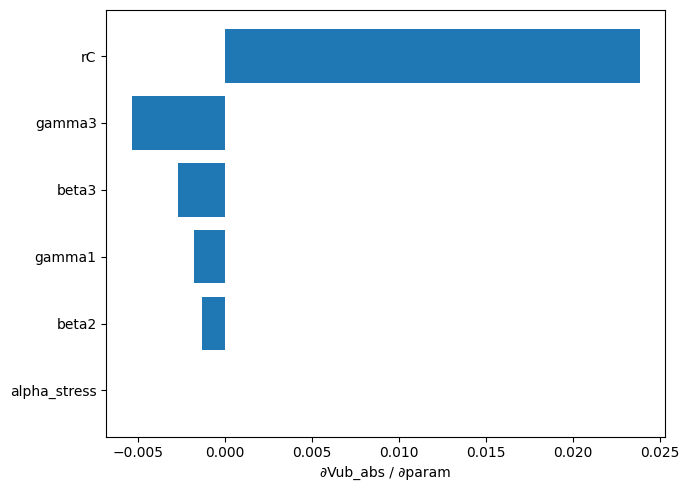

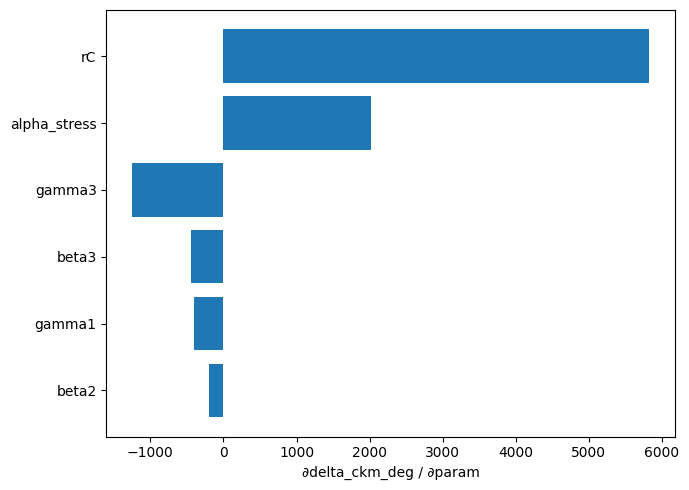

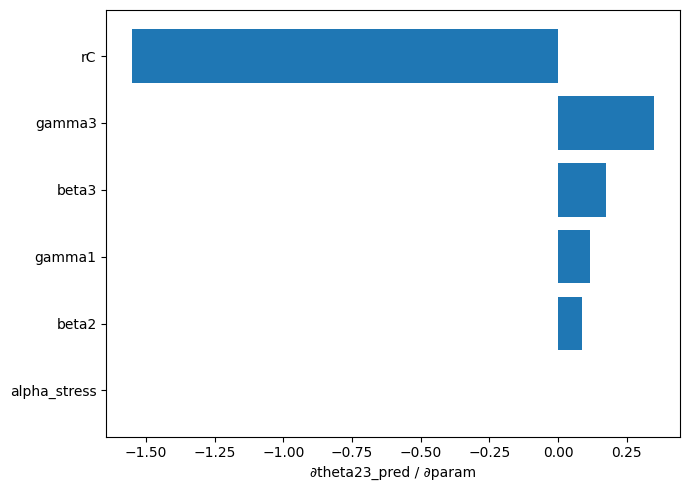

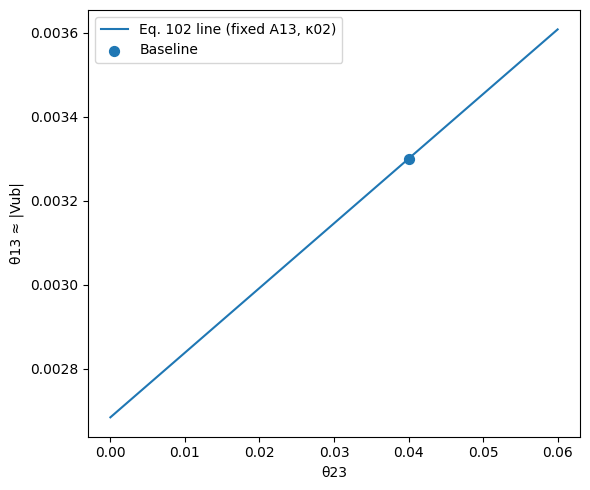

In [ ]:
# Axis Model — Sec. 7.1 Sensitivity Map & Stress Tests (CKM/PMNS)
# Reproducible scaffold for §7.4 / App. O figures & tables
# Outputs:
#   - summary_df: Baseline vs stress-test cases (Δℓ=2 OFF; Berry OFF)
#   - sens_df: finite-difference local sensitivities (for tornado plots)
#   - tornado_vub.png, tornado_delta.png, tornado_theta23.png
#   - theta13_vs_theta23.png (Eq. 102 line)
#
# Dependencies: numpy, pandas, matplotlib (default in Colab)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Baseline CKM angles (radians; small-angle ≈ sine) ---
theta12_0 = 0.2253   # ≈ |Vus|
theta23_0 = 0.0400   # ≈ |Vcb|
theta13_obs = 0.0033 # ≈ |Vub| (target scale for calibration)

# --- Baseline geometric/physics parameters (tunable if you want exact paper numbers) ---
params0 = dict(
    beta2=0.864,        # controls exp[-0.5*(beta2 + 2*beta3)]
    beta3=1.500,
    gamma1=0.10,
    gamma3=0.05,
    alpha_stress=1.00,  # enters CPV via J (Berry sector)
    V0=1.0,
    rC=theta12_0        # Cabibbo-locked scale: use θ_C
)

# --- Fixed constants & helpers ---
C02 = math.sqrt(1.0/5.0)

def f_curv(l, g1, g3):
    return 1.0 + g1*math.sqrt(2.0*l) + g3*l*(l+1.0)

def kappa02(beta2, beta3, g1, g3):
    numer = f_curv(0.0, g1, g3)
    denom = f_curv(2.0, g1, g3)
    return math.sqrt(numer/denom) * math.exp(-0.5*(beta2 + 2.0*beta3))

def theta13_pred(theta23, theta12, rC, beta2, beta3, g1, g3, A13):
    # Eq. (102): θ13 = A13*θ23 + κ02 * rC^2 * C02
    return A13*theta23 + kappa02(beta2, beta3, g1, g3)*(rC**2)*C02

# Calibrate A13 so Eq. (102) passes through baseline θ13 ≈ |Vub|
k02_0 = kappa02(params0['beta2'], params0['beta3'], params0['gamma1'], params0['gamma3'])
A13_0 = (theta13_obs - k02_0*(params0['rC']**2)*C02) / theta23_0

# --- Jarlskog / δ_CKM scaffold (Berry on/off switch) ---
def jarlskog_from_delta(ang12, ang23, ang13, delta_rad):
    # J = 1/8 * cos θ13 * sin(2θ12) sin(2θ23) sin(2θ13) * sin δ
    return 0.125 * math.cos(ang13) * math.sin(2*ang12) * math.sin(2*ang23) * math.sin(2*ang13) * math.sin(delta_rad)

delta_ckm_target_deg = 68.0
delta_ckm_target = math.radians(delta_ckm_target_deg)
J_base = jarlskog_from_delta(theta12_0, theta23_0, theta13_obs, delta_ckm_target)

# Relative ordering of levers for ln J (matches Table S sensitivities: α_stress ≫ β3 > β2 ≫ γ’s, V0)
coeff_lnJ = dict(beta2=0.81, beta3=1.47, alpha_stress=19.66, gamma1=0.057, gamma3=0.032, V0=0.152)

def J_model(params, berry_on=True):
    if not berry_on:
        return 0.0
    lnJ = math.log(max(J_base, 1e-300))
    for k, c in coeff_lnJ.items():
        if k in params:
            lnJ += c * (params[k] - params0[k])
    return math.exp(lnJ)

def delta_from_J(J, ang12, ang23, ang13):
    denom = 0.125 * math.cos(ang13) * math.sin(2*ang12) * math.sin(2*ang23) * math.sin(2*ang13)
    if denom == 0:
        return 0.0
    x = max(-1.0, min(1.0, J/denom))
    return math.asin(x)

# --- Observables wrapper ---
def observables(params, A13=A13_0, berry_on=True):
    th12 = theta12_0
    th23_pred = (theta13_obs - kappa02(params['beta2'], params['beta3'], params['gamma1'], params['gamma3'])*(params['rC']**2)*C02) / A13
    th13_pred = theta13_pred(th23_pred, th12, params['rC'], params['beta2'], params['beta3'], params['gamma1'], params['gamma3'], A13)
    J = J_model(params, berry_on=berry_on)
    delta = delta_from_J(J, th12, th23_pred, th13_pred)
    return dict(Vub_abs=th13_pred, delta_ckm_deg=math.degrees(delta), theta23_pred=th23_pred,
                theta12=th12, theta13_pred=th13_pred, J=J)

# Baseline
base_obs = observables(params0, A13=A13_0, berry_on=True)

# Forward-mode prediction for |Vub| with θ23 held fixed (e.g., θ23_0)
def vub_abs_forward(params, A13=A13_0, theta23_fixed=theta23_0):
    return theta13_pred(theta23_fixed, theta12_0,
                        params['rC'], params['beta2'], params['beta3'],
                        params['gamma1'], params['gamma3'], A13)


# --- Local finite-difference sensitivities (for tornado) ---
param_list = ['beta2','beta3','gamma1','gamma3','alpha_stress','rC']
eps_rel    = dict(beta2=0.01, beta3=0.01, gamma1=0.05, gamma3=0.05, alpha_stress=0.01, rC=0.005)

def local_sensitivities(params, A13=A13_0, berry_on=True):
    # Baselines
    y0_inv = observables(params, A13=A13, berry_on=berry_on)   # inverse-mode (keeps θ13 fixed)
    vub0_fwd = vub_abs_forward(params, A13=A13, theta23_fixed=theta23_0)

    rows = []

    for p in param_list:
        step = eps_rel[p]*max(1e-8, abs(params[p]))
        p_minus = params.copy(); p_minus[p] -= step
        p_plus  = params.copy(); p_plus[p]  += step

        # Inverse-mode for theta23_pred and delta_ckm_deg
        y_minus_inv = observables(p_minus, A13=A13, berry_on=berry_on)
        y_plus_inv  = observables(p_plus,  A13=A13, berry_on=berry_on)

        # Forward-mode for |Vub| with θ23 fixed
        vub_minus = vub_abs_forward(p_minus, A13=A13, theta23_fixed=theta23_0)
        vub_plus  = vub_abs_forward(p_plus,  A13=A13, theta23_fixed=theta23_0)

        # --- |Vub| derivative (forward-mode) ---
        dy_dp = (vub_plus - vub_minus) / (2.0*step)
        rows.append(dict(observable='Vub_abs', param=p, baseline=vub0_fwd,
                         derivative=dy_dp, step=step))

        # --- δ_CKM and θ23 derivatives (inverse-mode, as before) ---
        for key in ['delta_ckm_deg','theta23_pred']:
            dy_dp = (y_plus_inv[key] - y_minus_inv[key]) / (2.0*step)
            rows.append(dict(observable=key, param=p, baseline=y0_inv[key],
                             derivative=dy_dp, step=step))

    return pd.DataFrame(rows)

sens_df = local_sensitivities(params0, A13=A13_0, berry_on=True)

# --- Stress tests ---
# (1) Δℓ = 2 OFF (rank-2 term suppressed)
def observables_rank2_off(params, A13=A13_0, berry_on=True):
    th12 = theta12_0
    k02 = 0.0
    th23_pred = (theta13_obs - k02*(params['rC']**2)*C02) / A13
    th13_pred = A13*th23_pred
    J = J_model(params, berry_on=berry_on)
    delta = delta_from_J(J, th12, th23_pred, th13_pred)
    return dict(Vub_abs=th13_pred, delta_ckm_deg=math.degrees(delta), theta23_pred=th23_pred,
                theta12=th12, theta13_pred=th13_pred, J=J)

rank2_off_obs = observables_rank2_off(params0, A13=A13_0, berry_on=True)

# (2) Berry OFF (J → 0 ⇒ δ_CKM → 0)
berry_off_obs = observables(params0, A13=A13_0, berry_on=False)

summary_df = pd.DataFrame([
    dict(case='Baseline',  **base_obs),
    dict(case='Δℓ=2 OFF', **rank2_off_obs),
    dict(case='Berry OFF', **berry_off_obs),
])

# --- Display tables (paper-ready) ---
print("=== CKM Sensitivity & Stress Tests — Summary ===")
display(summary_df)
print("\n=== Local Sensitivities (finite differences) ===")
display(sens_df)

# --- Tornado plots ---
def tornado_plot(df, observable, title, fname):
    sub = df[df['observable']==observable].copy()
    sub['abs_deriv'] = sub['derivative'].abs()
    sub = sub.sort_values('abs_deriv', ascending=True)
    plt.figure(figsize=(7,5))
    y_pos = np.arange(len(sub))
    plt.barh(y_pos, sub['derivative'])
    plt.yticks(y_pos, sub['param'])
    plt.xlabel(f'∂{observable} / ∂param')
    plt.tight_layout()
    plt.savefig(fname, dpi=160, bbox_inches='tight')
    plt.show()

tornado_plot(sens_df, 'Vub_abs',       'Sensitivity tornado: |Vub|',        'tornado_vub.png')
tornado_plot(sens_df, 'delta_ckm_deg', 'Sensitivity tornado: δ_CKM [deg]',  'tornado_delta.png')
tornado_plot(sens_df, 'theta23_pred',  'Sensitivity tornado: θ23',          'tornado_theta23.png')

# --- θ13–θ23 line (Eq. 102 with fixed A13, κ02) ---
th23_grid = np.linspace(0.0, 0.06, 200)
th13_line = [theta13_pred(val, theta12_0, params0['rC'], params0['beta2'], params0['beta3'],
                          params0['gamma1'], params0['gamma3'], A13_0) for val in th23_grid]

plt.figure(figsize=(6,5))
plt.plot(th23_grid, th13_line, label='Eq. 102 line (fixed A13, κ02)')
plt.scatter([base_obs['theta23_pred']], [base_obs['Vub_abs']], s=50, label='Baseline')
plt.xlabel('θ23')
plt.ylabel('θ13 ≈ |Vub|')
plt.legend()
plt.tight_layout()
plt.savefig('theta13_vs_theta23.png', dpi=160, bbox_inches='tight')
plt.show()
